# Assignments 1 & 2

Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame. 

By aggregating data in following ways:
* by country
* by region

answer which are the best universities in terms of: 
* ratio between faculty members and students
* ratio of international students

Plot your data using bar charts and describe briefly what you observed.

Repeat previous analysis with data available on the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Discuss briefly what you observed.

### Libraries

In [1]:
import difflib, re, requests, unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup as bs
from IPython.core import display as ICD # Used to display multiple dataframes from same cell


### Constants

In [2]:
pd.options.mode.chained_assignment = None

# URLs
TOP_UNIVERSITIES_BASE_URL = 'https://www.topuniversities.com'
TOP_UNIVERSITIES_RANKNING_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1507982846110'
TIMES_HIGHER_EDUCATION_BASE_URL = 'https://www.timeshighereducation.com'
TIMES_HIGHER_EDUCATION_RANKING_URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

# Columns in data frames
TOTAL_STAFF_COUNT = 'total_staff_count'
INTERNATIONAL_STAFF_COUNT = 'international_staff_count'
TOTAL_STUDENT_COUNT = 'total_student_count'
INTERNATIONAL_STUDENT_COUNT = 'international_student_count'

### Helper functions

In [3]:
def form_region_dictionary(items, country_key, region_key):
    dictionary = {}
    for item in items:
        # If region is present, update it's contents if needed
        if (item[region_key] in dictionary) and (item[country_key] not in dictionary[item[region_key]]):
            dictionary[item[region_key]].append(item[country_key])
        # If region is not present, create it and put first item
        elif item[region_key] not in dictionary:
            dictionary[item[region_key]] = [item[country_key]]
    return dictionary

def add_region(item, country_key, region_dictionary, default_value='Unknown'):
    result = item.copy()
    result['region'] = default_value
    
    for region, countries in region_dictionary.items():
        if result[country_key] in countries:
            result['region'] = region
            break
    
    return result

def percentage_from_string(word):
    perc = word.strip()
    if perc[-1:] == '%':
        perc = perc[:-1]
    return float(perc) / 100

def int_from_string(word):
    return int("".join(i for i in list(word.strip()) if i.isdigit()))

def float_from_string(word):
    return float("".join(i for i in list(word.strip()) if i.isdigit() or i=='.'))

### Helper functions particular to information obtained from 'Top Universities' ranking site

In [4]:
def tu_parse_ranking(json):
    return list(map(lambda wrapper: { 
            'country' : wrapper['country'],
            'name' : wrapper['title'], 
            'rank' : wrapper['rank_display'], 
            'region' : wrapper['region'],
            'url' : wrapper['url']
        }, json))

def tu_staff_and_students(university):    
    UNI_URL = TOP_UNIVERSITIES_BASE_URL + university['url']
    r = requests.get(UNI_URL)
    
    soup = bs(r.text, 'html.parser')
    result = university.copy()
    
    # Total faculty staff count
    total_staff_wrapper = soup.find('div', class_='total faculty')
    total_staff_count = 0
    
    if total_staff_wrapper:
        total_staff_count = int_from_string(total_staff_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STAFF_COUNT] = total_staff_count
    
    # International faculty staff count
    international_staff_wrapper = soup.find('div', class_='inter faculty')
    international_staff_count = 0
    
    if international_staff_wrapper:
        international_staff_count = int_from_string(international_staff_wrapper.find('div', class_='number').text)

    result[INTERNATIONAL_STAFF_COUNT] = international_staff_count
    
    # Total students count
    total_student_wrapper = soup.find('div', class_='total student')
    total_student_count = 0
    
    if total_student_wrapper:
        total_student_count = int_from_string(total_student_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    
    # International students count
    international_student_wrapper = soup.find('div', class_='total inter')
    international_student_count = 0
    
    if international_student_wrapper:
        international_student_count = int_from_string(international_student_wrapper.find('div', class_='number').text)
    
    result[INTERNATIONAL_STUDENT_COUNT] = international_student_count
    
    return result


### Helper functions particular to information obtained from 'Times Higher Education' ranking site

*Note:* 'Times Higher Education' ranking site does not provide information on international staff members. For this reason, values in resulting 'the_df' data frame have value 0 associated with international staff count for all universities.

In [5]:
def the_parse_ranking(json):
    return list(map(lambda wrapper: {
            'country' : wrapper['location'],
            'name' : wrapper['name'],
            'rank' : wrapper['rank'],
            'url' : wrapper['url']
        }, json))

def the_staff_and_students(university):
    UNI_URL = TIMES_HIGHER_EDUCATION_BASE_URL + university['url']
    r = requests.get(UNI_URL)

    soup = bs(r.text, 'html.parser')
    result = university.copy()

    pane = soup.find('div', class_='panel-pane pane-data-stats')
    elements = pane.find_all('li')
    
    international_student_perc = None
    staff_to_student_ratio = None
    total_student_count = None
    
    for element in elements:
        # International student percentage        
        if element.find('div', class_='keystats pc_intl_students') != None:
            international_student_perc_text = element.find('div', class_='value').text
            international_student_perc = percentage_from_string(international_student_perc_text)
        # Total faculty staff ratio
        elif element.find('div', class_='keystats student_staff_ratio') != None:
            staff_to_student_ratio_text = element.find('div', class_='value').text
            staff_to_student_ratio = float_from_string(staff_to_student_ratio_text)
        # Total student count
        elif element.find('div', class_='keystats number_students') != None:
            total_student_count_text = element.find('div', class_='value').text
            total_student_count = int_from_string(total_student_count_text)
    
    result[TOTAL_STAFF_COUNT] = int(total_student_count / staff_to_student_ratio)
    
    # There is no data avilable on international staff count
    result[INTERNATIONAL_STAFF_COUNT] = 0
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    result[INTERNATIONAL_STUDENT_COUNT] = int(total_student_count * international_student_perc)
        
    return result

### Data retrieval

#### Retrieving data from 'Top Universities' ranking site and forming data frame

In [69]:
r = requests.get(TOP_UNIVERSITIES_RANKNING_URL)
response_json = r.json()['data'][:200]

universities = tu_parse_ranking(response_json)
universities = list(map(tu_staff_and_students, universities))

tu_df = pd.DataFrame.from_dict(universities)

#### Constructing region dictionary

In the next part of the exercise we will retrieve data from 'Times Higher Education' university ranking website which does not have region information coupled with information about the universities. We can solve this problem by forming 'region dictionary' whose keys will be regions introduced in 'Top Universities' data frame, and whose values will be countries associated with said regions and which were also introduced in 'Top Universities' data frame.

In [70]:
region_dictionary = form_region_dictionary(response_json, 'country', 'region')

Furthermore, we will manually add two more countries to the region dictionary that are not present in the 'Top Universities' data frame, and which are present in 'Times Higher Education' data frame. These countries are Russian Federation and Luxembourg, both now being associated with the European region.

In [71]:
region_dictionary['Europe'].append('Russian Federation')
region_dictionary['Europe'].append('Luxembourg')

#### Retrieving data from 'Times Higher Education' ranking site and forming data frame

In [72]:
r = requests.get(TIMES_HIGHER_EDUCATION_RANKING_URL)
response_json = r.json()['data'][:200]

universities = the_parse_ranking(response_json)
universities = list(map(lambda u: add_region(u, 'country', region_dictionary), universities))
universities = list(map(the_staff_and_students, universities))

the_df = pd.DataFrame.from_dict(universities)

#### Adjusting ranks in data frames

Data frames which we obtained from both ranking sites contain ranks which are not unique to every univeristy. Cases exist where serveral universities share the same rank. We will adjust this and make the rank unique to each university in each dataframe, by respecting original ordering in which univerities appeared on respective ladders.

In [73]:
tu_df['rank'] = range(1, len(tu_df['rank']) + 1)
the_df['rank'] = range(1, len(the_df['rank']) + 1)

#### Preserving obtained ranking infromation

We will save obtained data frames in binary files to avoid recrawling both ranking sites during the rest of the research.

In [7]:
the_df.to_pickle("the_dataset")
tu_df.to_pickle("tu_dataset")

We proceed with reading from saved files for the rest of the research.

In [6]:
the_df = pd.read_pickle("the_dataset")
tu_df = pd.read_pickle("tu_dataset")

## Top Universities data

#### Exploring the data

We will answer the following questions for the www.topuniversities.com dataset:

 - Which are the best universities in terms of:
     1. ratio between faculty members and students
     2. ratio of international students

We also show the same statistics per country and per region

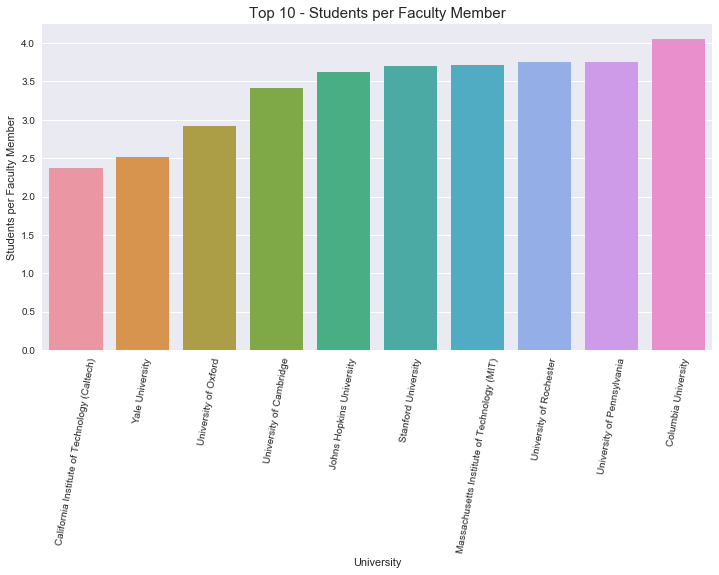

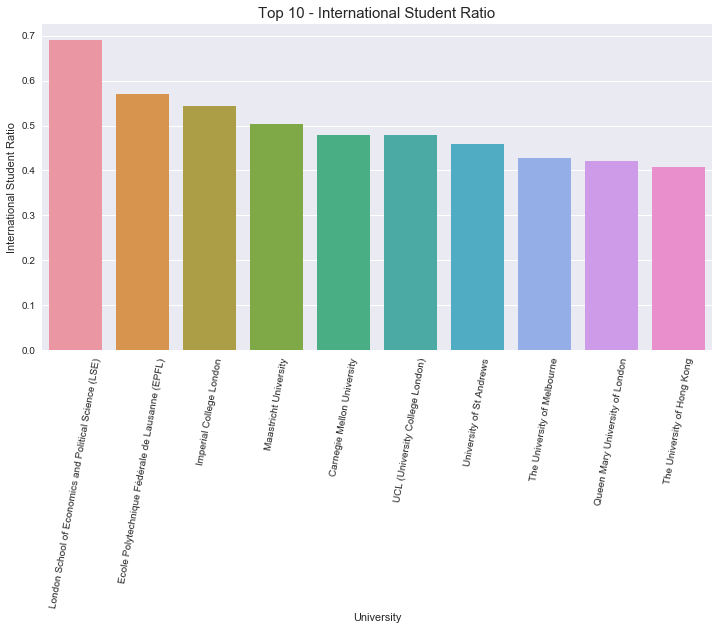

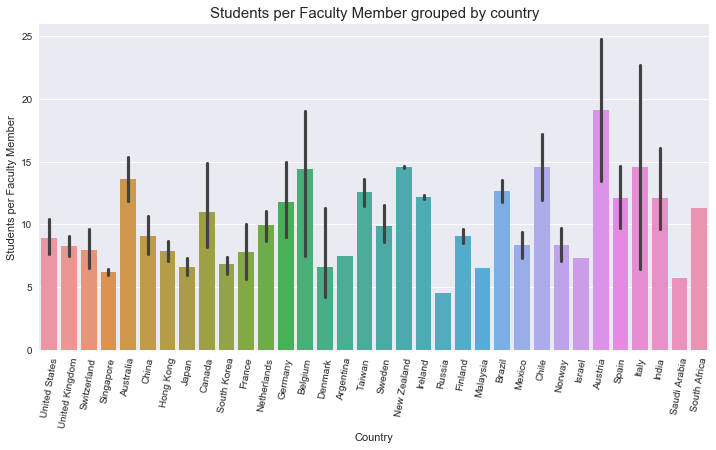

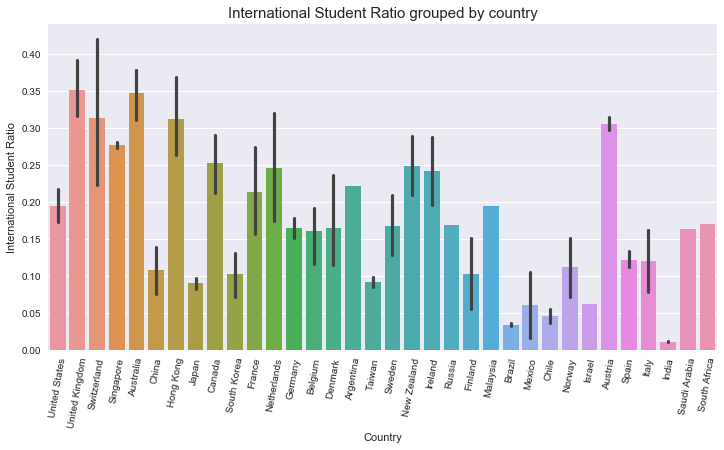

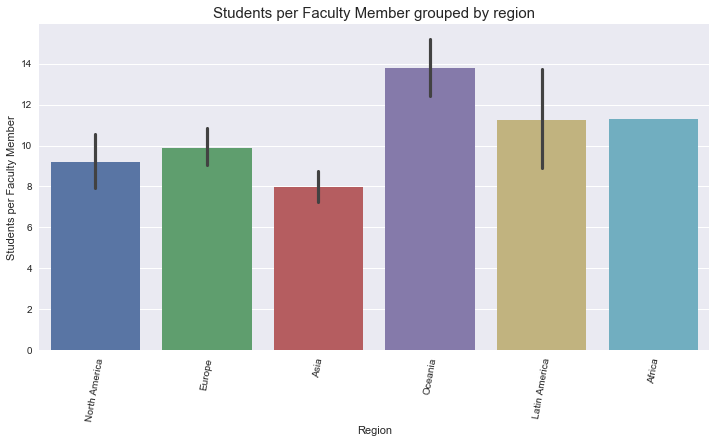

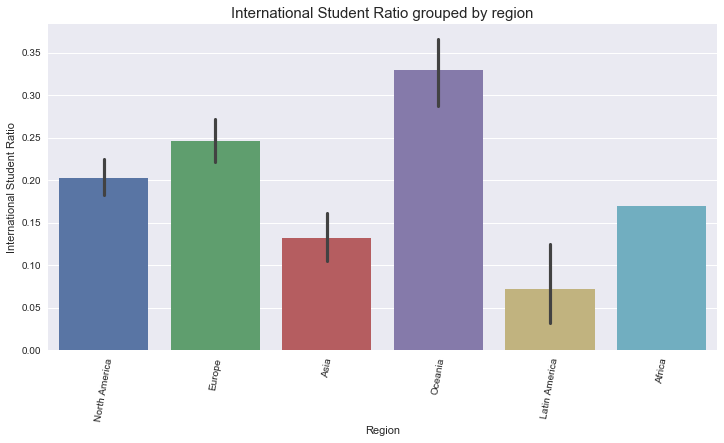

In [42]:
plot_labels = {
    'total_student_count': 'Students per Faculty Member',
    'international_student_count': 'International Student Ratio',
    'country': 'Country',
    'region' : 'Region'
}

def plot_ratio(df, stat, groupby=None, print_table=False):
    # create plot
    fig, ax = plt.subplots()
    
    # calculate ratio
    if stat == 'staff':
        asc = True
        col_name = plot_labels['total_student_count']
        ratio = df['total_student_count'].div(df['total_staff_count'])
    elif stat == 'int':
        asc = False
        col_name = plot_labels['international_student_count']
        ratio = df['international_student_count'].div(df['total_student_count'])

    if groupby is not None:
        title = col_name + " grouped by " + groupby
        
        # create new dataframe
        fsr = pd.concat([df[groupby], ratio], axis=1)
        lbl = plot_labels[groupby]
        fsr.columns = [lbl, col_name]
        fsr_g = fsr.groupby([lbl])[col_name].mean().to_frame()
        fsr_g['std'] = fsr.groupby([lbl])[col_name].std().to_frame()
        if print_table:
            ICD.display(fsr_g)
        sns.barplot(x=lbl, y=col_name, data=fsr, ax=ax)
    else:
        title = "Top 10 - " + col_name
        
        # create new dataframe
        fsr = pd.concat([df.name, ratio], axis=1)
        fsr.columns = ['University', col_name]
        fsr = fsr.sort_values(by=col_name, ascending=asc)[:10]
        if print_table:
            ICD.display(fsr)
        sns.barplot(fsr['University'], fsr[col_name], ax=ax)

    ax.set_title(title, fontsize=15)
    plt.rcParams['figure.figsize']=(12,6)
    plt.xticks(rotation=80)
    plt.ylabel(col_name)
    return plt

# tu plots
plot_ratio(tu_df, 'staff').show()
plot_ratio(tu_df, 'int', ).show()
plot_ratio(tu_df, 'staff', 'country').show()
plot_ratio(tu_df, 'int', 'country').show()
plot_ratio(tu_df, 'staff', 'region').show()
plot_ratio(tu_df, 'int', 'region').show()

## Times Higher Education data

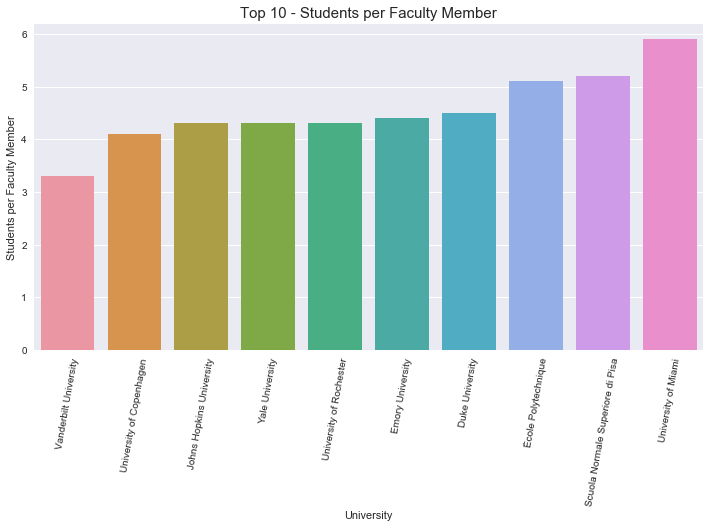

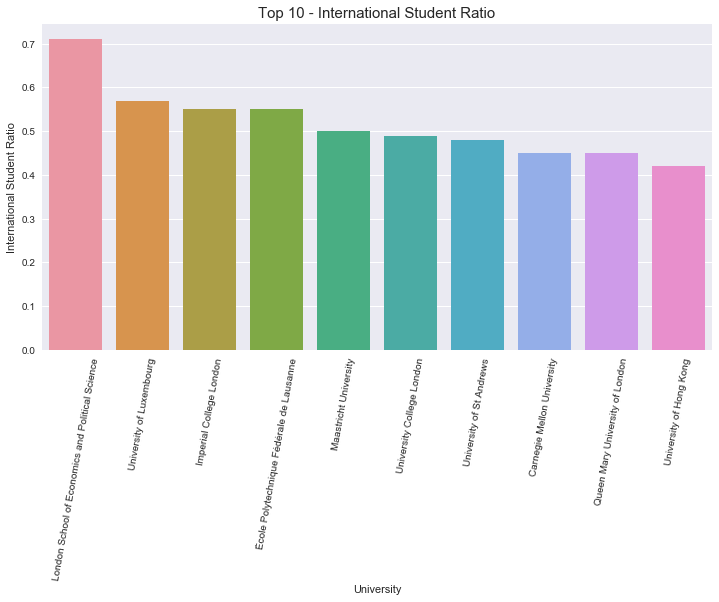

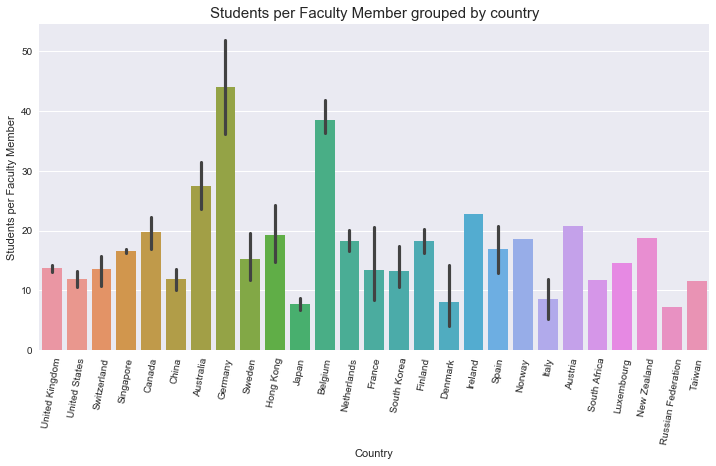

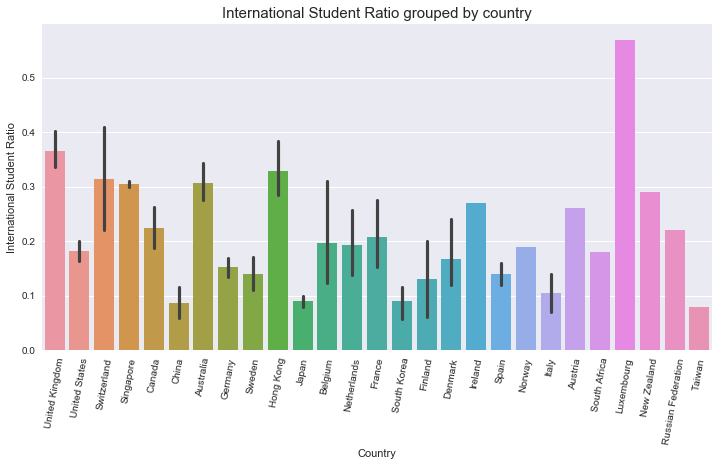

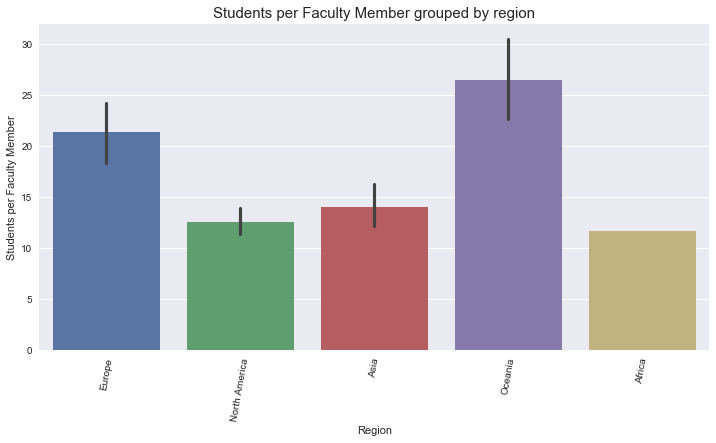

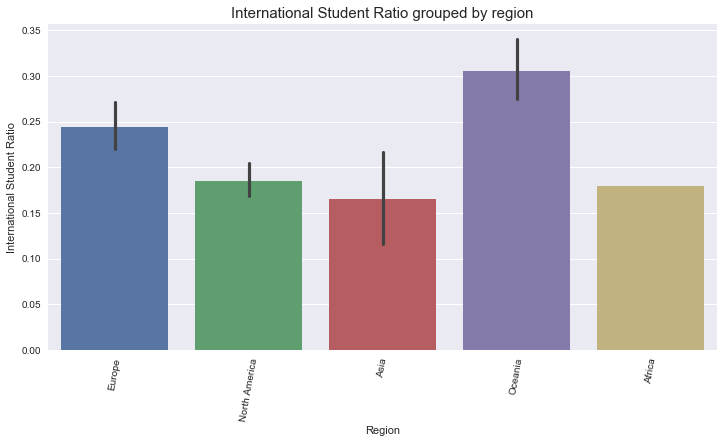

In [9]:
# the plots
plot_ratio(the_df, 'staff').show()
plot_ratio(the_df, 'int', ).show()
plot_ratio(the_df, 'staff', 'country').show()
plot_ratio(the_df, 'int', 'country').show()
plot_ratio(the_df, 'staff', 'region').show()
plot_ratio(the_df, 'int', 'region').show()

#### Discussion of Plots

The two metrics, students per faculty member and international student ratio, to not seem to predict each other on a per university or per country basis. That is, a high students per faculty member ratio does not seem to imply a high international student ratio and vice versa. Interestingly if we group the data by region, the two metrics do seem to be correlated, especially for the data from Times Higher Education.

# Assignment 3
### Matching entries by name

Let us look at the universities that are present in both data sets. Some are present in both rankings, and some are unique to either ranking. We should make sure that each university only occurs once in each dataset to avoid Problems when matching the two sets. 

In [43]:
tu_names_unique = len(set(tu_df['name'])) == len(list(tu_df['name']))
the_names_unique = len(set(the_df['name'])) == len(list(the_df['name']))

print("University names of tu_df are uniqe: {}".format(tu_names_unique))
print("University names of the_df are uniqe: {}".format(the_names_unique))

University names of tu_df are uniqe: True
University names of the_df are uniqe: True


The names of the universities are unique. Now let us find out how many are identical in both datasets.

In [44]:
# University names for both rankings
the_names = set(the_df.name)
tu_names = set(tu_df.name)

# University names present in both data sets
in_both = the_names.intersection(tu_names)
print("Number of universities in both rankings: {}".format(len(in_both)))

# University names only present in the_names
only_in_the = the_names.difference(tu_names)
print("Number of universities only in the_names: {}".format(len(only_in_the)))

# University names only present in tu_names
only_in_tu = tu_names.difference(the_names)
print("Number of universities only in tu_names: {}".format(len(only_in_tu)))

Number of universities in both rankings: 105
Number of universities only in the_names: 95
Number of universities only in tu_names: 95


Of the 95 unmatched university names we will try to match as many as possible between the two data sets using the following approach:

* Replace all unicode characters by ASCII characters
* Strip common words (e.g. 'University', 'College', etc.)
* Sort words in university name string lexicographically

Using the 'get_close_matches' function of the python module 'difflib' this allows us to match another 44 university names quite easily.

In [45]:
# Some common words to ignore when comparing university names
common_words = ['University', 'Science',  'Technology', 'The', 'College', 
                'Institute', '–',  'National', 'Ecole', 'Polytechnique', 
                'and', 'Universidad', '-', 'State', 
                'Université', '&']

def clean_string(string):
    # replace unicode by ascii
    string = unidecode.unidecode(string)
    # remove common words
    for word in common_words:
        string = string.replace(word, '')
    # sort words lexicographically
    string = ' '.join(sorted(string.split(' ')))
    return string

def find_matches(word, words):
    """
    Find closest string 'word' in list of strings 'words'
    """
    lookup = {}
    word = clean_string(word)
    cleaned = set()
    for entry in words:
        temp = clean_string(entry)
        cleaned.add(temp)
        lookup[temp] = entry
    return lookup, difflib.get_close_matches(word, cleaned, n=1, cutoff=0.7)

def create_matching_dict():
    """
    Creates the dictionary used for matching varying university names
    """
    matching_dict = {}
    for word in list(only_in_the):
        lookup, matches = find_matches(word, only_in_tu)
        if matches:
            matching_dict[word] = lookup[matches[0]]
    return matching_dict

def patch_df(df):
    """
    Function to 'patch' university names to allow merging of universities
    with slightly varying names
    """
    df_c = df.copy()
    matching_dict = create_matching_dict()
    for i, name in enumerate(df_c.name):
        if name in matching_dict:
            df_c.name[i] = matching_dict[name]
    return df_c

In [32]:
merged_df = pd.merge(patch_df(the_df), tu_df, how='inner', on=['name', 'region'], suffixes=('_the', '_tu'))
merged_df.head()

,country_the,international_staff_count_the,international_student_count_the,name,rank_the,region,total_staff_count_the,total_student_count_the,url_the,total_staff_student_ratio_the,...,international_student_count_tu,rank_tu,total_staff_count_tu,total_student_count_tu,url_tu,international_staff_student_ratio,total_staff_student_ratio_tu,international_to_total_student_ratio,international_to_total_staff_ratio,nubbed_ranking_tu
0,United Kingdom,0,7755,University of Oxford,1,Europe,1822,20409,/world-university-rankings/university-oxford,0.089274,...,7353,6,6750,19720,/universities/university-oxford,2.480769,0.342292,0.372870,0.439111,0.109057
1,United Kingdom,0,6436,University of Cambridge,2,Europe,1687,18389,/world-university-rankings/university-cambridge,0.091740,...,6699,5,5490,18770,/universities/university-cambridge,2.940737,0.292488,0.356899,0.414936,0.097089
2,United States,0,596,California Institute of Technology (Caltech),3,North America,339,2209,/world-university-rankings/california-institut...,0.153463,...,647,4,953,2255,/universities/california-institute-technology-...,1.848571,0.422616,0.286918,0.367261,0.117232
3,United States,0,3485,Stanford University,4,North America,2112,15845,/world-university-rankings/stanford-university,0.133291,...,3611,2,4285,15878,/universities/stanford-university,1.768364,0.269870,0.227422,0.476546,0.089172
4,United States,0,3800,Massachusetts Institute of Technology (MIT),5,North America,1284,11177,/world-university-rankings/massachusetts-insti...,0.114879,...,3717,1,2982,11067,/universities/massachusetts-institute-technolo...,2.213818,0.269450,0.335863,0.563045,0.098835


# Assignment 4

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

## Manipulating data

Before starting further analysis, we will expand our data frames with additional information that is valuable for exploratory analysis of each website's utilized technique and correlation present between the data parameters.

'Top Universities' data frame is expanded with the following columns:

* Total staff to student ratio
* International to total student ratio
* Interantional to total staff ratio
* Nubbed (degenerated) ranking which mimics portion of website's ranking system

'Times Higher Education' data frame is expanded with following columns:

* Total staff to student ratio
* International to domestic student ratio
* Nubbed (degenerated) ranking which mimics portion of website's ranking system

In both of the data frames, we have transformed 'region' attribute to a numerical one in order to try to find a correlation with the other variables, since we will be performing calculation of correlation between numerical values in our data frames.

Moreover, we have decided to discard the column regarding international staff count from the 'Times Higher Education' data frame, because it would be meaningless to perform any correlation computation with this attribute.

#### Prepairing 'Top Universities' data

In [15]:
tu_df['international_staff_student_ratio'] = tu_df.international_student_count / tu_df.international_staff_count
tu_df['total_staff_student_ratio'] = tu_df.total_staff_count / tu_df.total_student_count
tu_df['international_to_total_student_ratio'] = tu_df.international_student_count / tu_df.total_student_count
tu_df['international_to_total_staff_ratio'] = tu_df.international_staff_count / tu_df.total_staff_count
tu_df['nubbed_ranking'] = \
    0.05 * tu_df['international_to_total_student_ratio']\
    + 0.05 * tu_df['international_to_total_staff_ratio']\
    + 0.2 * tu_df['total_staff_student_ratio']

tur_df = tu_df.copy()
tur_df['region'] = tur_df.region.replace({'Europe': 0, 'North America': 1, 'Asia': 2, 'Oceania': 3, 'Latin America': 4, 'Africa': 5})

#### Prepairing 'Times Higher Education' data

In [16]:
the_df['total_staff_student_ratio'] = the_df.total_staff_count / the_df.total_student_count
the_df['international_to_domestic_student_ratio'] = the_df.international_student_count/\
    (the_df.total_student_count - the_df.international_student_count)
the_df['nubbed_ranking'] = \
    0.045 * the_df['total_staff_student_ratio']\
    + 0.025 * the_df['international_to_domestic_student_ratio']
    
ther_df = the_df.copy()
ther_df['region'] = ther_df.region.replace({'Europe': 0, 'North America': 1, 'Asia': 2, 'Oceania': 3, 'Unknown': 4, 'Africa': 5})
ther_df = ther_df.drop(['international_staff_count'], axis=1)

#### Correlation information regarding 'Top Universities' data

In [17]:
tur_df.corr()

,international_staff_count,international_student_count,rank,region,total_staff_count,total_student_count,international_staff_student_ratio,total_staff_student_ratio,international_to_total_student_ratio,international_to_total_staff_ratio,nubbed_ranking
international_staff_count,1.000000,0.646589,-0.531141,0.033634,0.596562,0.318303,-0.313711,0.326779,0.430129,0.585817,0.604058
international_student_count,0.646589,1.000000,-0.302378,0.048427,0.476709,0.562818,0.012382,-0.177791,0.539897,0.319030,0.196589
rank,-0.531141,-0.302378,1.000000,-0.063218,-0.308296,-0.033159,0.261191,-0.421397,-0.369427,-0.362852,-0.544849
region,0.033634,0.048427,-0.063218,1.000000,0.208480,0.270792,-0.097057,-0.076045,-0.253971,-0.086356,-0.165145
total_staff_count,0.596562,0.476709,-0.308296,0.208480,1.000000,0.767160,-0.165532,0.260203,-0.069686,-0.118996,0.090212
total_student_count,0.318303,0.562818,-0.033159,0.270792,0.767160,1.000000,0.054530,-0.315515,-0.171006,-0.204908,-0.345428
international_staff_student_ratio,-0.313711,0.012382,0.261191,-0.097057,-0.165532,0.054530,1.000000,-0.249677,-0.055605,-0.376615,-0.346434
total_staff_student_ratio,0.326779,-0.177791,-0.421397,-0.076045,0.260203,-0.315515,-0.249677,1.000000,0.128050,0.102992,0.721117
international_to_total_student_ratio,0.430129,0.539897,-0.369427,-0.253971,-0.069686,-0.171006,-0.055605,0.128050,1.000000,0.684095,0.696803
international_to_total_staff_ratio,0.585817,0.319030,-0.362852,-0.086356,-0.118996,-0.204908,-0.376615,0.102992,0.684095,1.000000,0.726797


#### Correlation information regarding 'Times Higer Education' data

In [18]:
ther_df.corr()

,international_student_count,rank,region,total_staff_count,total_student_count,total_staff_student_ratio,international_to_domestic_student_ratio,nubbed_ranking
international_student_count,1.000000,-0.328642,0.155380,0.275584,0.578362,-0.261509,0.401963,0.304248
rank,-0.328642,1.000000,-0.153276,-0.247216,-0.151142,-0.152068,-0.193915,-0.230932
region,0.155380,-0.153276,1.000000,0.225605,0.213274,0.076667,-0.128160,-0.099035
total_staff_count,0.275584,-0.247216,0.225605,1.000000,0.568346,0.485920,-0.202262,-0.045917
total_student_count,0.578362,-0.151142,0.213274,0.568346,1.000000,-0.319088,-0.271646,-0.355582
total_staff_student_ratio,-0.261509,-0.152068,0.076667,0.485920,-0.319088,1.000000,-0.001760,0.300797
international_to_domestic_student_ratio,0.401963,-0.193915,-0.128160,-0.202262,-0.271646,-0.001760,1.000000,0.953157
nubbed_ranking,0.304248,-0.230932,-0.099035,-0.045917,-0.355582,0.300797,0.953157,1.000000


## Data visualization 

In this section we will try to obtain more information from our data with the help of plots, such as pairplots and boxplots. Pairplots are useful in visualising the strength of correlation, while boxplots can help us visualize different distributions between certain data types.

#### Pairplot with 'Top Universities' data

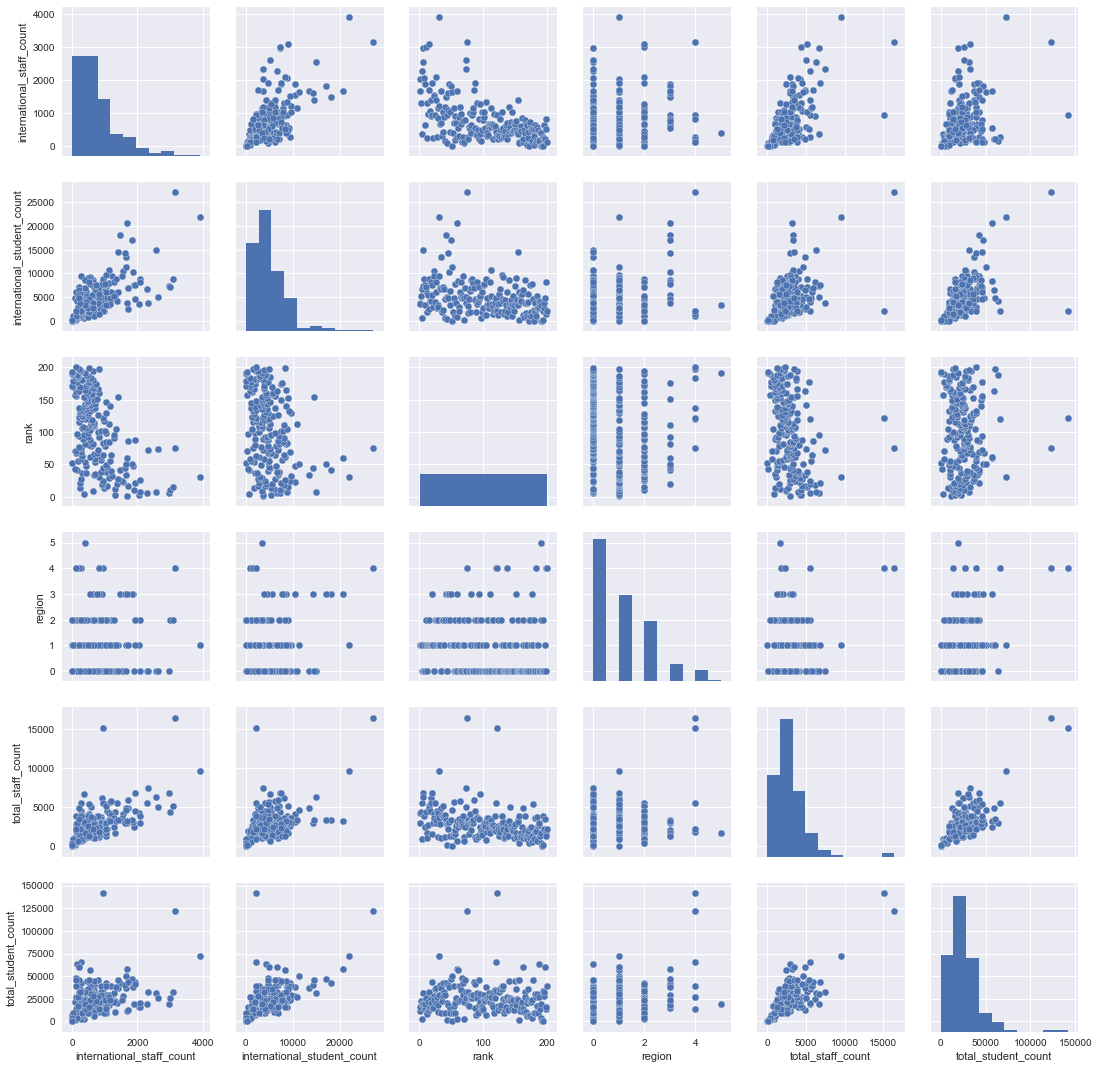

In [19]:
tur_df = tur_df.drop(['international_staff_student_ratio',\
                      'total_staff_student_ratio',\
                      'international_to_total_student_ratio',\
                      'international_to_total_staff_ratio',\
                      'nubbed_ranking'], axis=1)
sns.pairplot(tur_df)

#### Pairplot with 'Times Higher Education' data

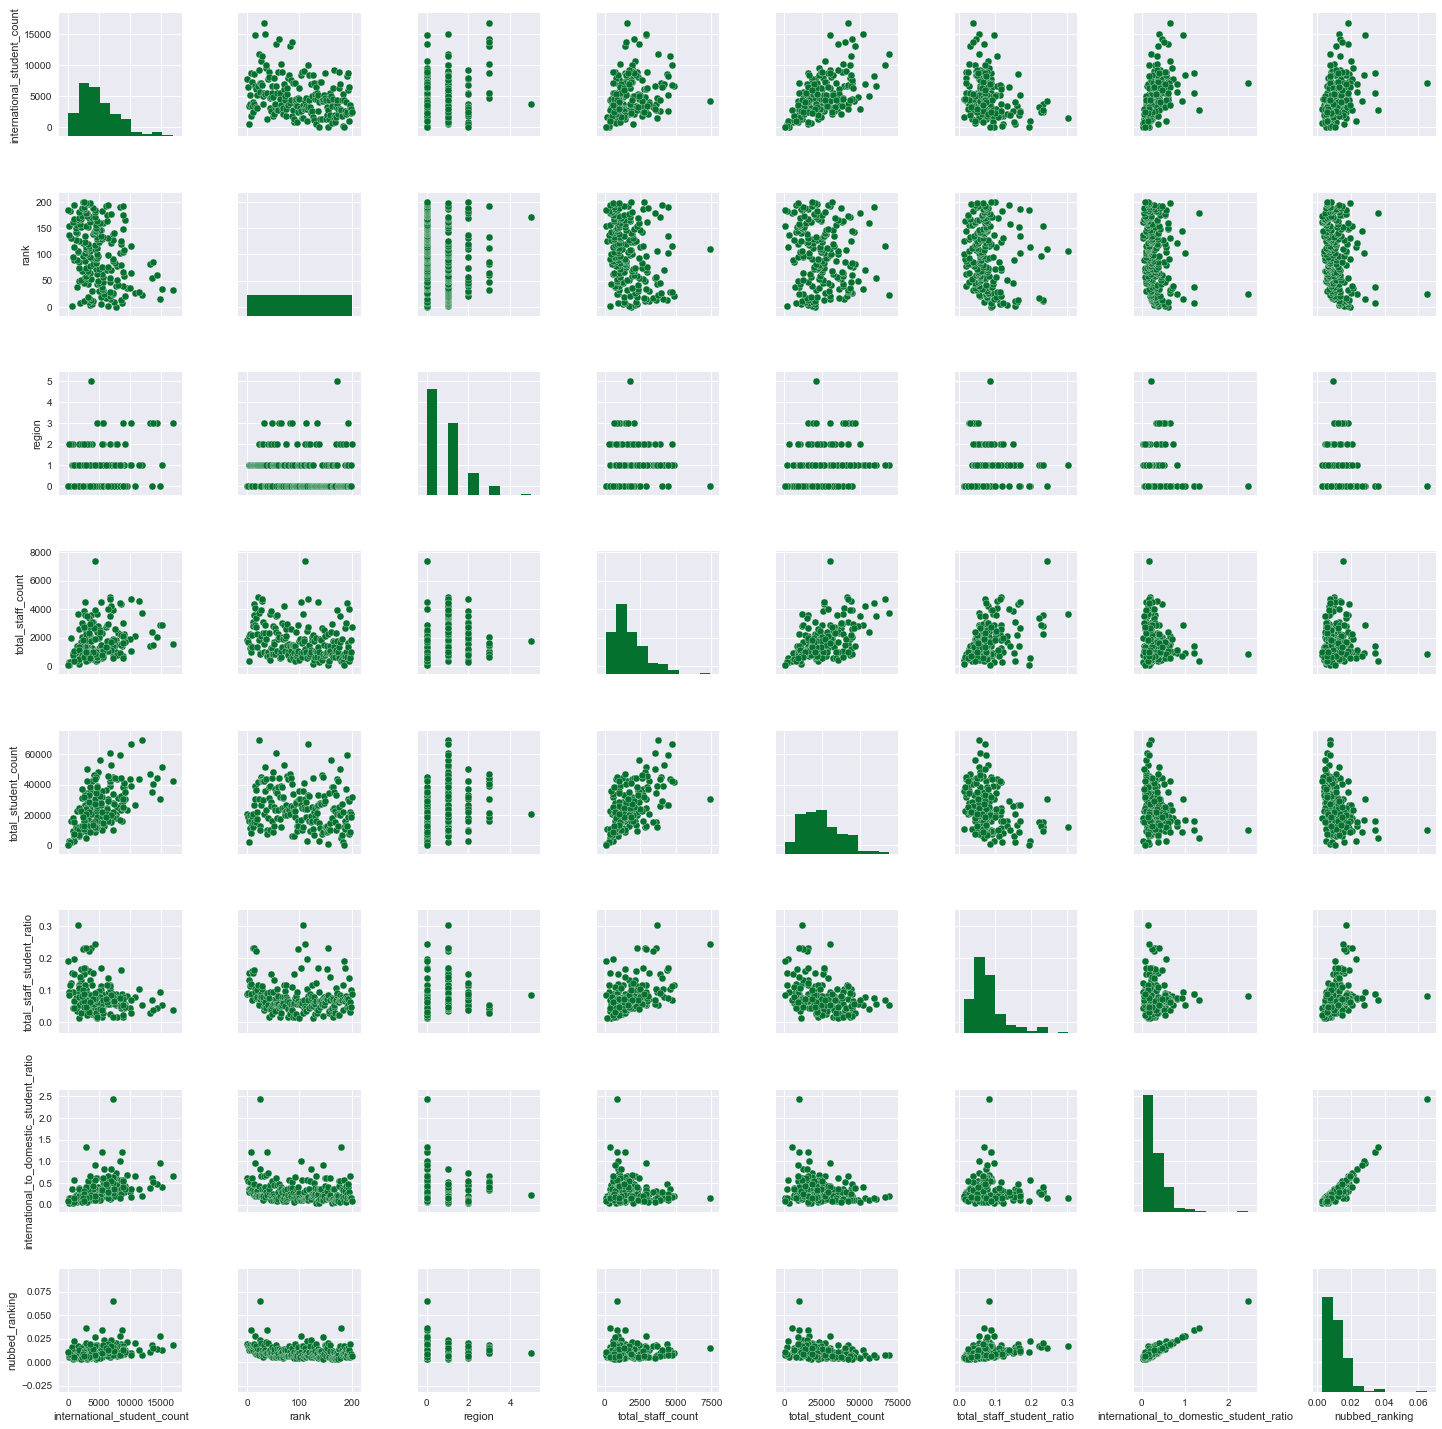

In [20]:
with sns.color_palette("BuGn_r"):
    sns.pairplot(ther_df )

### Observations regarding data correlation

Before commenting resulting correlation tables and pairplots, we should take a moment and reflect on how these ranking websites actually calculate ranking for each university. 

Quality of correlation information between parameters (which are not 'rank') relies on quality and precision of information provided by the websites themselves. On the other hand, conclusions inferred from correlation information of parameters obtained and ranks themselves should be viewed in the context of ranking system that these websites use. Ranking websites favor observed qualities (parameters) differently, and use formulas which weigh those properties differently in the resulting overall score.

We will briefly refer to those ranking practices during observation of results obtained by correlation analysis. Furthermore, we will revisit assumptions we made before doing the actual statistical analysis and see how those assumptions hold up.

#### 'Top Universities' [[ranking methodology](https://www.topuniversities.com/qs-world-university-rankings/methodology)]

We observe highest correlation between parameters linked with international outreach of universities. The number of international students is significantly correlated with the number of international staff members (further observed through correlation of their ratios). On the other hand, we do not observe strong correlation between parameters of international outlook and university rankings. While referring to the ranking methodology utilized by 'Top Universities' website, we observe that international outlook accounts for only 5% of the overall university score for both students and staff members respectively.

Faculty staff to student ratio makes for 20% of the overall university score, with the website stating that teaching quality is typically cited by students as the metric of highest importance to them when comparing institutions using a ranking. In our correlation test we found a very small negative correlation between faculty/student ratio and ranking.

While having websites ranking methodology in mind, we tried to recreate degenerated ranking value with parameter weighing as it is done by ranking website. We weighted ratio of international to total students by 5%, ratio of international to total staff members by 5%, and total faculty staff to student ratio by 20%. Resulting degenerated ranking shows significant negative correlation with overall ranking and supports ranking website's argumentation on contents of ranking score.

#### 'Times Higher Education' [[ranking methodology](https://www.timeshighereducation.com/world-university-rankings/methodology-world-university-rankings-2018#survey-answer)]

We observe highest correlation between parameters which are directly dependent: number of international students and total number of students, and their ratio. Other correlation values do not present themselves as being statistically significant, so we will continue with study of site's ranking methodology.

Faculty staff to student ratio amounts to 4.5% of the overall university's score. In our correlation test we found a very small negative correlation between faculty/student ratio and ranking, which is not statistically significant. Moreover, international to domestic student ratio amounts to 2.5% of the overall university's score, and here as well we observe that there is no statistically significant correlation present with overall ranking.

Finally, we utilized the same approach to creating degenerated ranking value from parameters which we have in our research data frame, in hopes of explaining at least a portion of the overall ranking score calculated by the ranking website itself. Resulting degenerated ranking does not show a significant negative correlation which would account for at least a portion of the overall university's score. This result is expected if we take into account overall ranking methodology. Parameters that we are utilizing in our research amount to only 7% of the overall ranking score, and further exploratory research is needed in hopes of transparently argumenting website's ranking system.

#### Final remarks regarding correlation analysis

We will touch on the subject of correlation between overall ranking values and region/country of observed universities. Any type of correlation between rank and geographic location would signal bias in a ranking algorithm that these ranking websites have towards certain regions. 

In our analysis we did not observe any statistically significant correlation between university's region/country and its overall score. This is true for both of website's rankings. This finding supports website's ranking argumentation which do not make any mention about the geographical location of university having an impact on the overall score.

### Boxplots and striplot 

Even though we did not find a clear correlation between the university's region ant it's rank, we would like to understand the regional spread of top universities. In order to give a more intuitive visualization, we have decided to perform this analysis by utilising box and strip plots, while first observing top 25 and then top 50 universities.

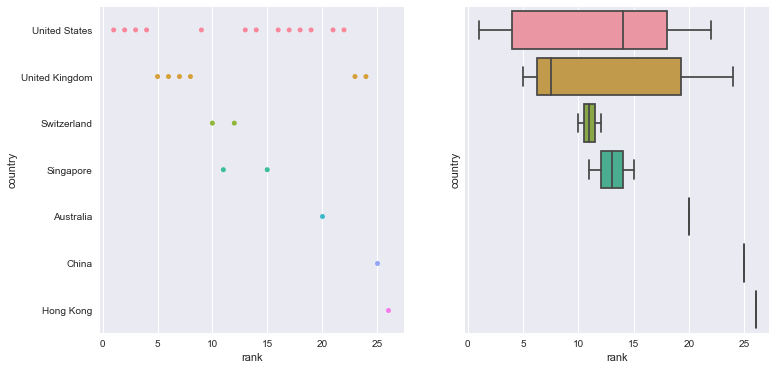

In [21]:
tur_df=tu_df.loc[:25]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.stripplot(x="rank", y="country", data=tur_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=tur_df, ax=ax2);

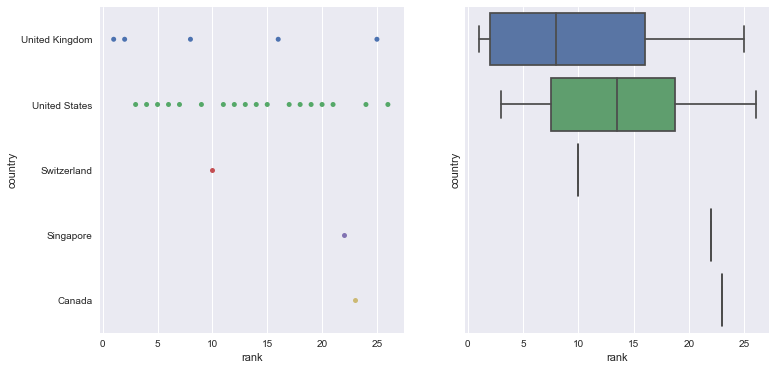

In [22]:
ther_df=the_df.loc[:25]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.stripplot(x="rank", y="country", data=ther_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=ther_df, ax=ax2);

By analysing the plots, we find that the largest portion of the top universities are placed in the western hemisphere. Moreover, the top positions are dominated by American and British universities. 

Universities from the eastern hemisphere that first appear in both ranks come from Singapore: in the 'Top Universities' ranking that is 'Nanyang Technological University' (placed 11th), while in 'Times Higher Education' ranking that is 'National University of Singapore' (placed 22th). 

In the overall ranking of top 25 universities, 'Top Universities' has 5, while 'Times Higher Education' has only 1 university that is positioned in the eastern hemisphere.

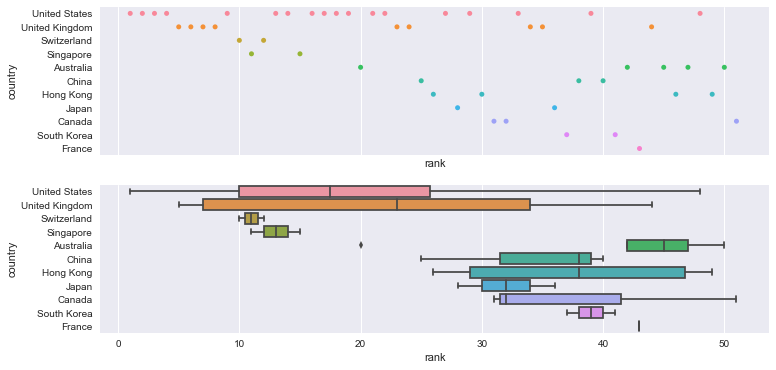

In [23]:
tur_df=tu_df.loc[:50]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

sns.stripplot(x="rank", y="country", data=tur_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=tur_df, ax=ax2);

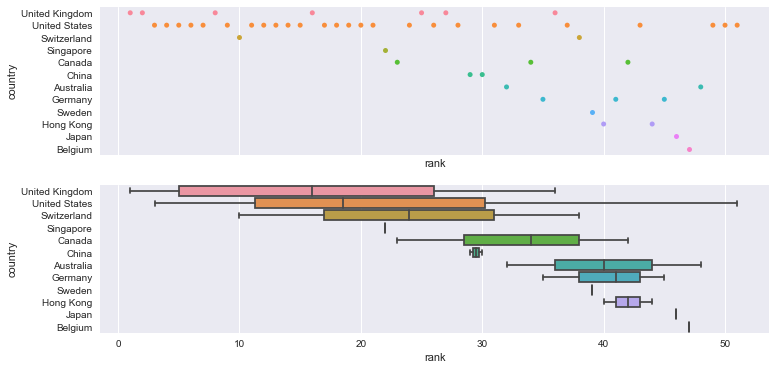

In [24]:
ther_df=the_df.loc[:50]
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)

sns.stripplot(x="rank", y="country", data=ther_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=ther_df, ax=ax2);

Considering the plots of top 50 universities, we notice the same trend that was present earlier regarding lack of universities from the eastern hemisphere:

* 'Top Universities' ranking has 16 universities from the eastern hemisphere
* 'Times Higher Education' ranking has 8 universities that are from the eastern hemisphere

# Assignment 5

Can you find the best university taking in consideration both rankings? Explain your approach.

After analysing the data, we have to come up with a unique rank that takes into consideration both websites' rankings. Their rankings are different for two main reasons: 

* they consider different parameters for calculating same (similar) variables (e.g. 'international outlook') 
* same (similar) variables are weighted differently according to website's final ranking formula

We want to utilise approach which will penalize universities that have different rankings between the websites, while assigning more 'negative points' to those universities that have bigger discrepancies between both rankings.

E.g. if we decide to merge both ranks using a simple mean, we are running into the risk of classifying a university which has 8th place in both ranks in the same way as the one that is in 6th place in one ranking, and 10th in the other ranking. For this reason, mean as a merging function will not suffice.

We are going to define a new function called 'penalized mean'. In order to penalize universities which have a significant discrepancy between their positions in both rankings, 'penalized mean' utilizes parameter $\alpha\in(0,1)$ that allows us to decide how much to penalize ranking fluctuation. For instance, setting $\alpha=0.20$ means that every 5 place difference in ranking positions will result in one additional loss of position compared to the simple mean value of ranks.

We can observe different ranking results in the short data frame snippet below. 'peanlized_mean_1' utilises value $\alpha=0.20$, while 'penalized_mean_2' utilises value $\alpha=0.25$.

In [25]:
def average(a,b):
    return (a + b) / 2

def penalized_mean(a, b, alpha):
    return average(a,b) + alpha * np.abs(a - b)

# Creating new dataset with university names and respective rankings
ranks = pd.DataFrame()
ranks['name'] = merged_df.name
ranks['rank_tu'] = merged_df.rank_tu
ranks['rank_the'] = merged_df.rank_the

# Classic mean
ranks['mean'] = average(merged_df.rank_tu, merged_df.rank_the)

# For ranking difference = 5; penalization of 1 ranking position
ranks['penalized_mean_1'] = penalized_mean(merged_df.rank_tu, merged_df.rank_the, 0.20)

# For ranking difference = 4; penalization of 1 ranking position
ranks['penalized_mean_2'] = penalized_mean(merged_df.rank_tu, merged_df.rank_the, 0.25)

ranks.head(15)

,name,rank_tu,rank_the,mean,penalized_mean_1,penalized_mean_2
0,University of Oxford,6,1,3.5,4.5,4.75
1,University of Cambridge,5,2,3.5,4.1,4.25
2,California Institute of Technology (Caltech),4,3,3.5,3.7,3.75
3,Stanford University,2,4,3.0,3.4,3.50
4,Massachusetts Institute of Technology (MIT),1,5,3.0,3.8,4.00
5,Massachusetts Institute of Technology (MIT),1,191,96.0,134.0,143.50
6,Harvard University,3,6,4.5,5.1,5.25
7,Princeton University,13,7,10.0,11.2,11.50
8,Imperial College London,8,8,8.0,8.0,8.00
9,University of Chicago,9,9,9.0,9.0,9.00


We define a new function in order to calculate the ranks according to the metrics used. We add the results to our dataset.

In [26]:
def add_ranking(df, on_col):
    rank = df[on_col].sort_values()
    rank = pd.Series(np.arange(1, len(rank) + 1), index=rank.index)
    df['rank_'+ on_col] = rank

add_ranking(ranks, 'mean')
add_ranking(ranks, 'penalized_mean_1')
add_ranking(ranks, 'penalized_mean_2')

After presenting several approaches to calculating combined rank for universities, we decide to proceed with penalized mean approach that uses $\alpha=0.20$.

In [27]:
ranks = ranks.sort_values(by='rank_penalized_mean_1')

final_rank = pd.DataFrame()
final_rank['Name'] = ranks.name
final_rank['Rank'] = ranks.rank_penalized_mean_1
final_rank.set_index(['Rank'], inplace=True)
final_rank.head(25)

,Name
Rank,
1,Stanford University
2,California Institute of Technology (Caltech)
3,Massachusetts Institute of Technology (MIT)
4,University of Cambridge
5,University of Oxford
6,Harvard University
7,Imperial College London
8,University of Chicago
9,ETH Zurich - Swiss Federal Institute of Techno...
